# Mise à jour de la segmentation

Tout d'abord, il faut choisir le meilleur algorithme pour ceux testés en fonction du score.

J'ai choisi d'utiliser le silhouette score qui note la bonne attribution du cluster d'un individu en fonction du jeu de données de départ.

| Algorithme | Silhouette Score | Nb de clusters |
|--|--|--|
| RFM | 0.374 | 8 |
| KMeans | 0.397 | 8 |
| CAH | 0.756 | 6 |
| DBSCAN | 0.400 | 7 |

Je choisis donc d'utiliser le CAH avec 6 clusters. C'est à partir de ce dernier de je vais faire mon analyse concernant la mise à jour des segments.

Il faut que je reparte du jeu de départ nommé "POLIST_11_raw_datas.csv"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

pd.set_option("display.max_columns", None)

raw_datas = pd.read_csv("POLIST_11_raw_datas.csv")
raw_datas

,order_id,customer_unique_id,customer_state,delivering_time,delivered_before_time,nb_score,score_mean,init_score,diff_score,purchase_date,purchase_y_m,purchase_y_q,purchase_y_s,purchase_y,days_last_purchase,pay_sum,installments_min,installments_max,installments_mean,installments_size,type_boleto,type_credit_card,type_debit_card,type_voucher,price_min,price_mean,price_max,price_sum,freight_value_min,freight_value_mean,freight_value_max,freight_value_sum,product_description_lenght_mean,product_photos_qty_mean,weight_min,weight_mean,weight_max,nb_product_min,nb_product_mean,nb_product_max,nb_product_sum,category__agro_industry_and_commerce,category__air_conditioning,category__art,category__arts_and_craftmanship,category__audio,category__auto,category__baby,category__bed_bath_table,category__books_general_interest,category__books_imported,category__books_technical,category__cds_dvds_musicals,category__christmas_supplies,category__cine_photo,category__computers,category__computers_accessories,category__consoles_games,category__construction_tools_construction,category__construction_tools_lights,category__construction_tools_safety,category__cool_stuff,category__costruction_tools_garden,category__costruction_tools_tools,category__diapers_and_hygiene,category__drinks,category__dvds_blu_ray,category__electronics,category__fashio_female_clothing,category__fashion_bags_accessories,category__fashion_childrens_clothes,category__fashion_male_clothing,category__fashion_shoes,category__fashion_sport,category__fashion_underwear_beach,category__fixed_telephony,category__flowers,category__food,category__food_drink,category__furniture_bedroom,category__furniture_decor,category__furniture_living_room,category__furniture_mattress_and_upholstery,category__garden_tools,category__health_beauty,category__home_appliances,category__home_appliances_2,category__home_comfort_2,category__home_confort,category__home_construction,category__housewares,category__industry_commerce_and_business,category__kitchen_dining_laundry_garden_furniture,category__kitchen_laptops_and_food_preparers,category__la_cuisine,category__luggage_accessories,category__market_place,category__music,category__musical_instruments,category__office_furniture,category__others,category__party_supplies,category__pc_gamer,category__perfumery,category__pet_shop,category__security_and_services,category__signaling_and_security,category__small_appliances,category__small_appliances_home_oven_and_coffee,category__sports_leisure,category__stationery,category__tablets_printing_image,category__telephony,category__toys,category__watches_gifts,seller_state__AC,seller_state__AM,seller_state__BA,seller_state__CE,seller_state__DF,seller_state__ES,seller_state__GO,seller_state__MA,seller_state__MG,seller_state__MS,seller_state__MT,seller_state__PA,seller_state__PB,seller_state__PE,seller_state__PI,seller_state__PR,seller_state__RJ,seller_state__RN,seller_state__RO,seller_state__RS,seller_state__SC,seller_state__SE,seller_state__SP
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,SP,8.0,True,1,4.0,4,0,2017-10-02,201710,20174,20172,2017,331,38.71,1,1,1.0,3,0.0,1.0,0.0,2.0,29.99,29.99,29.99,29.99,8.72,8.72,8.72,8.72,268.0,4.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,BA,12.0,True,1,4.0,4,0,2018-07-24,201807,20183,20182,2018,36,141.46,1,1,1.0,1,1.0,0.0,0.0,0.0,118.70,118.70,118.70,118.70,22.76,22.76,22.76,22.76,178.0,1.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Supposition de processus

~~~
1. Clusters initiaux:
   1. Je fit avec le CAH sur un échantillon de clients aléatoire à partir du jeu de données contenant les clients uniques ("POLIST_13_gpb_datas.csv").
   2. Je fit_transform tous les individus pour trouver leur cluster respectif.
2. Formatage du jeux de données:
   1. Je découpe "POLIST_11_raw_datas" en périodes de 1, 3, 6 mois et 1 an.
   2. Je formate les sous-jeux de "POLIST_11_raw_datas.csv" pour qu'il ressemble à "POLIST_13_gpb_datas.csv".
3. Prédictions:
   1. Je réutilise le modèle initial pour prédire les clusters des sous-jeux de "POLIST_11_raw_datas.csv".
   2. J'utilise l'**ARI** pour comparer les clusters prédits aux initiaux.
   3. Je récupère les scores.
4. Résultats finaux:
   1. Je trace un graphe pour afficher l'évolution des scores au cours du temps.
~~~
1. Formatage du jeux de données:
   1. J'encode "POLIST_11_raw_datas.csv".
   2. Je découpe "POLIST_11_raw_datas" en périodes de 1, 3, 6 mois et 1 an.
   3. Je formate les sous-jeux de "POLIST_11_raw_datas.csv" pour qu'il ressemble à "POLIST_13_gpb_datas.csv".
2. Sous-jeu initial:
   1. Je CAH.fit_predict() sur le sous-jeu initial.
   2. Je calcule les centroïdes avec NearestCentroid().
   3. J'attribue les clusters au sous-jeu suivant (clf.fit_predict()).
3. Autres sous-jeux:
   1. Je CAH.fit_predict() sur le sous-jeu
4. ARI sur sur les clusters des points 2. et 3.
5. Initialisation pour la prochaine comparaison:
   1. J'ajoute les nouveaux clients au sous-jeu initial.
   2. Je mets à jour les clusters des clients déjà présents dans le sous-jeu initial avec les nouveaux clusters.




In [2]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer


def override_null(init_datas):
    # J'extrais les features avec des valeurs nulles
    null_cols = []
    nb_null_list = []
    for col in init_datas.columns:
        nb_null = init_datas[col].isnull().sum()
        if nb_null > 0:
            # print(f"{col} => {nb_null}")
            # print(f"\tIntervalle: [{init_datas[col].min()}, " + 
            #     f"{init_datas[col].max()}]")
            null_cols.append(col)
            nb_null_list.append(nb_null)

    # Pour chaque feature extraite, je choisis la nouvelle valeur
    for col, nb_null in zip(null_cols, nb_null_list):
        new_val = np.float64(input(f"{col} => {nb_null} null" + 
            f"\tIntervalle: [{init_datas[col].min()}, " + 
            f"{init_datas[col].max()}]\nValeur de remplacement " + 
            f"(Écrire en notation scientifique): "))
        init_datas[col].fillna(new_val, inplace= True)
    
    return init_datas


def feat_encoding(raw_datas):
    datas_cat_cols = ["customer_state"]

    ct = ColumnTransformer([
        ("encoding", OrdinalEncoder(), datas_cat_cols)
    ])

    X_enc = pd.DataFrame(ct.fit_transform(raw_datas), columns= datas_cat_cols, 
                        index= raw_datas.index)

    other_cols = [x for x in raw_datas.columns if x not in ["customer_state"]]
    return pd.concat([X_enc, raw_datas[other_cols]], axis= 1)

In [3]:
import re


def cols_rename(data, name):
    rename_cols = {}
    for col in data.columns[1:]:
        rename_cols[col] = col + "_" + name

    return data.rename(rename_cols, axis= 1)


def datas_extraction(init_datas, start_date, max_months):
    end_date = start_date + pd.DateOffset(months= max_months, days= -1)

    date_datas = init_datas[(pd.to_datetime(init_datas["purchase_date"]) 
        >= start_date) & (pd.to_datetime(init_datas["purchase_date"]) <= 
        end_date)]

    start_date = end_date + pd.DateOffset(days= 1)

    ### agrégation des features
    # states
    tmp_states = date_datas.groupby("customer_unique_id", 
        as_index= False)[["purchase_date", "customer_state"]].min()

    # sums
    sum_cols = ["nb_score", "pay_sum", "nb_product_sum"]
    for col in date_datas.columns:
        if re.search(r"^category__.*", col) is not None:
            sum_cols.append(col)
        elif re.search(r"^type_.*", col) is not None:
            sum_cols.append(col)
        elif re.search(r"^seller_state__.*", col) is not None:
            sum_cols.append(col)
    tmp_sum = date_datas.groupby("customer_unique_id")[sum_cols].sum().reset_index()
    tmp_sum = cols_rename(tmp_sum, "sum")

    # frequency
    freq_datas = date_datas.groupby("customer_unique_id", as_index= False)["order_id"].count()
    freq_datas.rename({"order_id": "frequency"}, axis= 1, inplace= True)

    # means
    mean_cols = ["init_score", "delivering_time"]
    tmp_mean = date_datas.groupby("customer_unique_id")[mean_cols].mean().reset_index()
    tmp_mean = cols_rename(tmp_mean, "mean")

    # merge
    datas = tmp_states.merge(tmp_sum, on="customer_unique_id") # .merge(tmp_min, on="customer_unique_id")
    datas = datas.merge(freq_datas.merge(tmp_mean, on="customer_unique_id"), on= "customer_unique_id")

    return datas.copy(), start_date

In [4]:
def days_calculation(datas, max_date):
    datas["days_last_purchase_min"] = (
        pd.to_datetime(max_date) - 
        pd.to_datetime(datas["purchase_date"])
        ).apply(lambda x: x.days)

    return datas.copy()

In [5]:
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import adjusted_rand_score

def analysis_over_time(dataset, periods):
    init_datas = pd.read_csv(dataset)

    init_datas = override_null(init_datas)

    # Le CAH a besoin que la feature "customer_state" soit encodée 
    # par un OrdinalEncoder

    init_datas = feat_encoding(init_datas)

    # Il faut obtenir les scores à intervalle de temps régulier
    # Cela implique une date de début et une de fin

    final_date = pd.to_datetime(init_datas["purchase_date"].max())

    for period in periods:
        init_bool = True
        ari = []
        variation = []
        start_date = pd.to_datetime(init_datas["purchase_date"].min())
        
        while start_date < final_date:
            # J'extrais les sous-jeux de données découpés tous les 
            # 1, 3, 6, 12 mois
            # Il faut une date de fin pour l'intervalle de temps
            date_datas, start_date = datas_extraction(init_datas, start_date, period)

            # Je calcule le nombre de jours depuis le dernier achat
            date_datas =  days_calculation(date_datas, date_datas["purchase_date"].max())
            
            # A chaque nouvelle boucle, concat des df et groupby
            # sum sur toutes les features 
            # sauf mean sur "init_score_mean", "delivering_time_mean"
            # et min sur "days_last_purchase", "customer_state"
            # drop de "purchase_date"
            # Au premier tour, je sauvegarde le sous-jeu initial
            if init_bool:
                prev_datas = date_datas.copy()
                init_bool = False 
            
            else:
                # Dans le sous-jeu à comparer, il faut que je 
                # commence par mettre à jour les clients présents dans 
                # les deux jeux
                date_mean_cols = ["init_score_mean", "delivering_time_mean"]
                date_min_cols = ["days_last_purchase_min", "customer_state", "purchase_date"]
                date_sum_cols = [x for x in date_datas.columns if x not in date_mean_cols + date_min_cols]
                tmp_sum_datas = pd.concat([prev_datas, date_datas]).groupby("customer_unique_id", 
                    as_index= False)[date_sum_cols].sum()
                tmp_mean_datas = pd.concat([prev_datas, date_datas]).groupby("customer_unique_id", 
                    as_index= False)[date_mean_cols].mean()
                tmp_min_datas = pd.concat([prev_datas, date_datas]).groupby("customer_unique_id", 
                    as_index= False)[date_min_cols].min()
                tmp_datas = tmp_min_datas.merge(tmp_mean_datas.merge(tmp_sum_datas, on= 
                    "customer_unique_id"), on= "customer_unique_id")

                # J'exclus les features "customer_unique_id" et "purchase_date" pour le CAH
                CAH_cols = [x for x in tmp_datas.columns if x not in ["customer_unique_id", 
                    "purchase_date"]]

                ###
                # J'extrais les clients du sous-jeu à comparer
                new_datas = tmp_datas.loc[tmp_datas["customer_unique_id"].isin(date_datas[
                    "customer_unique_id"]), CAH_cols]

                # 2 individus minimum sont nécessaire pour le CAH
                # Si c'est le cas, je calcule l'ARI
                # Sinon j'attribue la valeur précédente de l'ARI à la liste
                if len(new_datas) > 1:
                    # Je CAH.fit sur le sous-jeu à comparer et garde les clusters
                    new_labels = AgglomerativeClustering(n_clusters= 6, linkage= "average", 
                        compute_full_tree= False).fit_predict(new_datas)

                    ###
                    # Je CAH.fit sur le sous-jeu initial et je calcule les centroïdes
                    # Je vais avoir un problème d'espace mémoire, je vais donc utiliser 
                    # les 30_000 individus les plus récents pour le CAH.fit()
                    ordered_datas = prev_datas.sort_values(by= "purchase_date")
                    ordered_datas = ordered_datas[CAH_cols]
                    
                    CAH_pred = AgglomerativeClustering(n_clusters= 6, linkage= "average", 
                        compute_full_tree= False).fit_predict(ordered_datas[-30_000:])

                    # Calcule des centroïdes
                    clf = NearestCentroid()
                    clf.fit(ordered_datas[-30_000:], CAH_pred)

                    # Prédiction des clusters du sous-jeu à comparer
                    init_labels = clf.predict(new_datas)

                    ###
                    # ARI sur les deux jeux de clusters
                    ari.append(adjusted_rand_score(init_labels, new_labels)) 
                    
                else:
                    if len(ari) > 0:
                        ari.append(ari[-1])
                    
                ###
                # J'attribue les nouvelles données à prev_datas et
                # je mets à jour le nombre de jours depuis le dernier achat
                prev_datas = tmp_datas.copy()
                prev_datas = days_calculation(prev_datas, date_datas["purchase_date"].max())

        # Affichage du graphique
        fig = plt.figure(figsize=(20, 7))
        
        plt.plot(ari, "bo-", label="ARI score")

        for i in np.arange(0, 1.1, 0.1):
            plt.axhline(i, ls= "--", c= "grey")
        
        plt.ylim(-0.1, 1.1)
        plt.xlabel(f"Echantillons de {period} mois")
        plt.legend()

        plt.show()


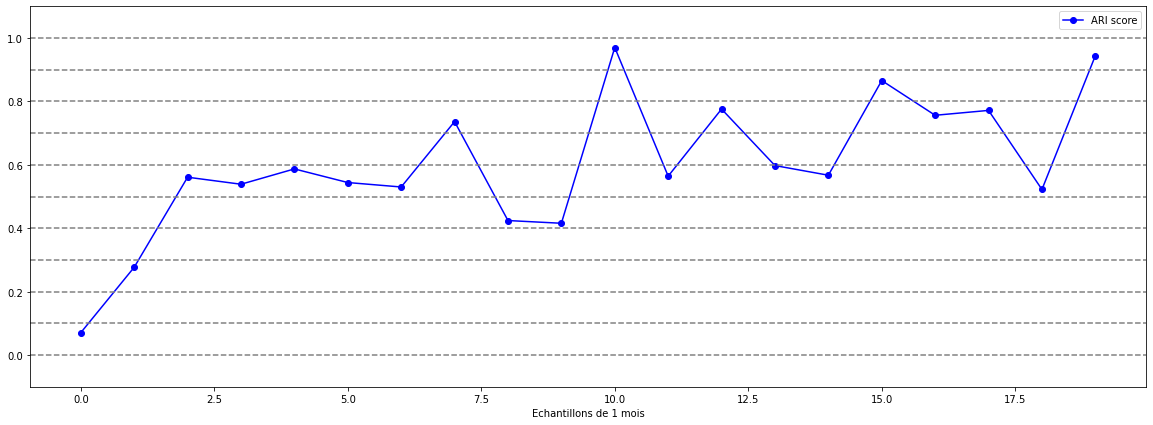

In [6]:
periods = [1]
analysis_over_time("POLIST_11_raw_datas.csv", periods)


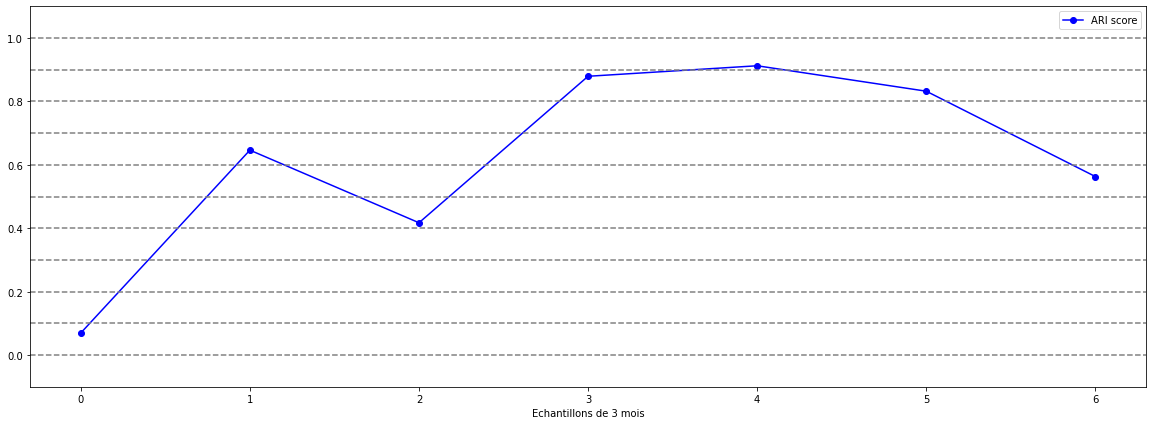

In [7]:
periods = [3]
analysis_over_time("POLIST_11_raw_datas.csv", periods)


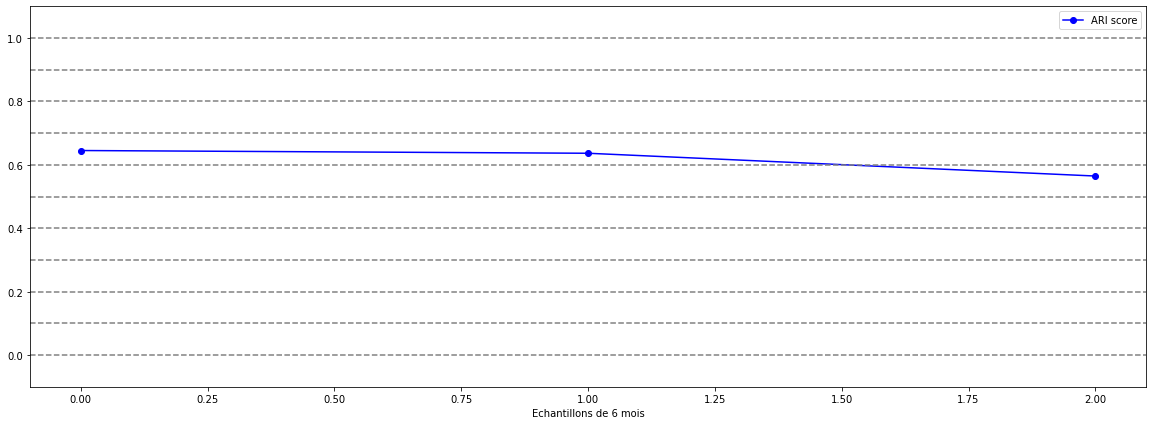

In [8]:
periods = [6]
analysis_over_time("POLIST_11_raw_datas.csv", periods)


***Il n'y a pas assez de données pour effectuer l'opération sur des échantillons de 12 mois.***

### Conclusion

J'obtiens donc trois graphiques pour des périodes de 1, 3 et 6 mois.
Je recherche des graphiques avec des résultats très variables pour définir la période d'actualisation des segments.
* Le graphique pour les périodes mensuelles affiche des valeurs très aléatoires. c'est un bon prétendant.
* Le graphique pour des périodes trimestrielles affiche des valeurs croissantes la première annnée puis semble plus ou moins stagner. Il reste néanmoins un bon prétendant aussi.
* Le graphique semestrielle est relativement linéaire. Je peux l'exclure d'office.

Parmi les deux prétendants, je garde le plus petit intervalle de temps pour l'actualisation des segments.

***Les segments devront donc être actualisées tous les mois.***